In [126]:
!pip install torch torchvision pillow numpy matplotlib opencv-python opencv-contrib-python torchsummary torchmetrics torchinfo  torchvision

In [127]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from PIL import Image, ImageEnhance
import numpy as np
import os
# from google.colab import drive
from matplotlib import pyplot as plt
from torchsummary import summary
from torchinfo import summary
import torchmetrics
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_curve, roc_auc_score
from torchmetrics.classification import BinaryROC

In [ ]:
##### Useful when running from Google Colab
# View current working directory
print("Current Working Directory:", os.getcwd())

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Confirm the change
print("Current Working Directory:", os.getcwd())

# Change working directory to your file position
path = "/content/drive/My Drive/"
os.chdir(path)

# Confirm the change
print("Working Directory:", os.getcwd())

In [140]:
#File paths
TrainCSVPath = "../data/kaggle/archive/csv/sample_train.csv"
ValCSVPath = "../data/kaggle/archive/csv/samp_mass_val.csv"
TestCSVPath = "../data/kaggle/archive/csv/mass_case_description_test_set.csv"
ImgPath = "../data/kaggle/archive/jpeg/"
OutPath = "./distentout/"

In [130]:
#need this because in the directory there was a ROI file and mass file
#The ROI file was always of bigger size, there was no other commanality 
#or file naming conventions or file names in meta data that could provide 
#this information. The smallest file in the dir was always a mass
def find_smallest_file(directory):
    """Finds the smallest file in the given directory."""
    # print('direc....', directory)
    smallest_file = None
    smallest_size = float('inf')

    for root, _, files in os.walk(directory):
        # print('files...............................', files)
        for file in files:
            file_path = os.path.join(root, file)
            file_size = os.path.getsize(file_path)

            if file_size < smallest_size:
                smallest_file = file_path
                smallest_size = file_size

    return smallest_file

In [131]:
def generate_comp_images(gland_path, mass_path):
    """
    Generates composite images by combining glands and mass image.

    Parameters:
    - gland_path: List of file paths for calc images.
    - mass_path: List of file paths for mass images.
    """
    # Load images
    gland_img_file = find_smallest_file(ImgPath + gland_path)
    # print('gland_img_file...................', gland_img_file)
    glands = Image.open(gland_img_file).convert("RGBA")
    mass_img_file = find_smallest_file(ImgPath + mass_path)
    # print('mass_img_file........................', mass_img_file)
    # print('___________________________________________________________________')
    mass = Image.open(mass_img_file).convert("RGBA")
    
    #Kinda working combo
    #pla around with brightness and contrast to illuminate the disentangle mass
    enh = ImageEnhance.Brightness(glands)
    glands = enh.enhance(1)
    enh = ImageEnhance.Brightness(mass)
    mass = enh.enhance(1)
    enh = ImageEnhance.Contrast(mass)
    mass = enh.enhance(2)

    # Resize glands and mass to match
    if glands.size != mass.size:
        mass = mass.resize(glands.size)

    # Composite the gland image over mass image using the alpha image
    composite = Image.alpha_composite(glands, mass)

    return composite, glands, mass, gland_img_file, mass_img_file

In [139]:
#Store the disentangled mass as a png file
def disentangle_img(img,fname):
    to_pil = transforms.ToPILImage()
    pil_image = to_pil(img)

    # Save the image as JPEG
    pil_image.save(OutPath + fname+ ".png", format="PNG")

In [133]:
# Define a simple DAB-Net architecture
class DABNet(nn.Module):
    def __init__(self, num_classes=2):
        super(DABNet, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(4, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        # Separate decoders for glands & mass
        self.decoder_glands = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 4, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
        self.decoder_mass = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 4, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
        
        # Classifier: Predict benign or malignant
        # self.classifier = nn.Sequential(
        #     nn.AdaptiveAvgPool2d(1),  
        #     nn.Flatten(),
        #     nn.Linear(256, num_classes),  
        # )        
        self.classifier = nn.Sequential(
            # nn.AdaptiveAvgPool2d((4,4)),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(256, 128),  
            nn.ReLU(),
            nn.Dropout(0.5),      
            nn.Linear(128, num_classes),
        )      
        
    def forward(self, x):
        # Encode
        encoded = self.encoder(x)
        # Decode separately
        calc = self.decoder_glands(encoded)
        mass = self.decoder_mass(encoded)

        malig = self.classifier(encoded)
        return calc, mass, malig

In [134]:
#Build the mass dataset by having a composite image of mass and glands
#the dataset also has the labels, composite image, mass, glands
class MassDataset(Dataset):
    def __init__(self, mass_data_csv, transform=None):
        self.data = pd.read_csv(mass_data_csv)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Load image and label
        gland_path = self.data.iloc[idx, 12]
        gland_path = gland_path.split('/')[2]
        mass_path = self.data.iloc[idx, 13]
        mass_path = mass_path.split('/')[2]
        label = 1 if self.data.iloc[idx, 9] == 'MALIGNANT' else 0

        # Open image
        comp_image, glands_img, mass_img, gland_img_file, mass_img_file= generate_comp_images(gland_path, mass_path)

        # Apply transforms
        if self.transform:
            comp_image = self.transform(comp_image)
            glands_img = self.transform(glands_img)
            mass_img = self.transform(mass_img)
            
        return comp_image, glands_img, mass_img, label, mass_img_file, gland_img_file


In [135]:
# Training settings
losses = []
accuracies = []
val_losses = []
val_accuracies = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

dataset = MassDataset(mass_data_csv=TrainCSVPath, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

labels = dataset.data['pathology'].values  
# print(type(labels), labels)
labels = np.where(labels == 'MALIGNANT', 1, 0)

# Compute cltype(ass weights)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)

# Convert to tensor
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
class_criterion = nn.CrossEntropyLoss()

print("Class Weights:", class_weights)


model = DABNet().to(device)
# criterion = nn.MSELoss()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

Class Weights: tensor([0.9705, 1.0313])


In [136]:
#Metod to run the validation dataset
def validate_ds():
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    num_epochs = 0
    
    valdataset = MassDataset(mass_data_csv=ValCSVPath, transform=transform)
    valdataloader = DataLoader(valdataset, batch_size=8, shuffle=False)
    
    with torch.no_grad():
        for i, (blended, calc_img, mass_img, labels, massfile, glandfile) in enumerate(valdataloader):
            comp, calc, mass = blended.to(device), calc_img.to(device), mass_img.to(device)
            pred_calc, pred_mass, malig = model(comp)
            loss_calc = criterion(pred_calc, calc)
            loss_mass = criterion(pred_mass, mass)
            loss_class = class_criterion(malig, labels)
            loss = loss_calc + loss_mass + loss_class
    
            val_loss += loss.item()
    
            _, predicted = torch.max(malig, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    val_loss /= len(valdataloader)
    val_accuracy = 100 * correct / total
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    return val_loss, val_accuracy

In [137]:
# training loop
def train(dataloader, model, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        total = 0
        correct = 0
        for i, (blended, calc_img, mass_img, labels, massfile, glandfile) in enumerate(dataloader):
            comp, calc, mass = blended.to(device), calc_img.to(device),\
                                                        mass_img.to(device)
            optimizer.zero_grad()

            # Forward pass
            pred_calc, pred_mass, malig = model(comp)
            # print('calc shape................', calc.shape)
            # print('pred_calc shape................', pred_calc)
            loss_calc = criterion(pred_calc, calc)
            loss_mass = criterion(pred_mass, mass)
            loss_class = class_criterion(malig, labels)
            loss = loss_calc + loss_mass + loss_class

            # Backward pass
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(malig, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            if i % 10 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], Loss: {loss.item():.4f}")

        losses.append(running_loss/len(dataloader))
        epoch_accuracy = 100 * correct / total
        accuracies.append(epoch_accuracy)
        print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {running_loss/len(dataloader):.4f}, Accuracy: {epoch_accuracy:.4f}")
        val_loss, val_acc = validate_ds()
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

In [138]:
##################Skip this part if you want to run from the pretrained model#################################
#the paper suggested around 500 epaochs
#Need 50 epoch to train right
train(dataloader, model, criterion, optimizer, num_epochs=100)

Epoch [1/100], Step [1/33], Loss: 2.1026
Epoch [1/100], Step [11/33], Loss: 2.0895
Epoch [1/100], Step [21/33], Loss: 2.0881
Epoch [1/100], Step [31/33], Loss: 2.0696
Epoch [1/100], Average Loss: 2.0866, Accuracy: 48.8615
Validation Loss: 2.0584, Validation Accuracy: 52.67%
Epoch [2/100], Step [1/33], Loss: 2.0497
Epoch [2/100], Step [11/33], Loss: 1.9687
Epoch [2/100], Step [21/33], Loss: 1.8927
Epoch [2/100], Step [31/33], Loss: 1.8353
Epoch [2/100], Average Loss: 1.9361, Accuracy: 52.2770
Validation Loss: 1.8389, Validation Accuracy: 48.85%
Epoch [3/100], Step [1/33], Loss: 1.8309
Epoch [3/100], Step [11/33], Loss: 1.7626
Epoch [3/100], Step [21/33], Loss: 1.7337
Epoch [3/100], Step [31/33], Loss: 1.7093
Epoch [3/100], Average Loss: 1.7565, Accuracy: 50.1898
Validation Loss: 1.7094, Validation Accuracy: 50.76%
Epoch [4/100], Step [1/33], Loss: 1.7218
Epoch [4/100], Step [11/33], Loss: 1.6012
Epoch [4/100], Step [21/33], Loss: 1.5802
Epoch [4/100], Step [31/33], Loss: 1.5844
Epoch [4

In [141]:
#Sae the model to file so it can be loaded later
torch.save({'model_state_run1':model.state_dict(), 
            'train_losses': losses, 
            'train_acc': accuracies,
            'val_losses': val_losses,
            'val_acc': val_accuracies
           }, 'DABNet.pth')

###################################################################################################################################
IF you want to run the saved model contunue running the code from this point onwards
###################################################################################################################################

In [142]:
#Load the saved model file
chkpnt = torch.load('DABNet.pth')
#Load the saved model now
model.load_state_dict(chkpnt['model_state_run1'])

C:\Users\rames\AppData\Local\Temp\ipykernel_12424\1753558732.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  chkpnt = torch.load('DABNet.pth')


<All keys matched successfully>

In [143]:
#Run the test dataset
tst_loss = 0
correct = 0
total = 0
num_epochs = 0
tst_losses = []
tst_accuracies = []
all_labels = []
all_probs = []

model.eval()

tstdataset = MassDataset(mass_data_csv=TestCSVPath, transform=transform)
tstdataloader = DataLoader(tstdataset, batch_size=8, shuffle=False)

with torch.no_grad():
    for i, (blended, calc_img, mass_img, labels, massfile, glandfile) in enumerate(tstdataloader):
        comp, calc, mass = blended.to(device), calc_img.to(device), mass_img.to(device)
        pred_calc, pred_mass, malig = model(comp)
        loss_calc = criterion(pred_calc, calc)
        loss_mass = criterion(pred_mass, mass)
        loss_class = class_criterion(malig, labels)
        loss = loss_calc + loss_mass + loss_class

        probs = torch.sigmoid(malig)
        # print('probs.....', probs)
        all_probs.append(probs.numpy())
        all_labels.append(labels.numpy())

        #Save the first predicted calcitrant glands and the mass
        fname_calc = "disent_calc"+"_" + str(i)
        fname_mass = "disent_mass"+"_" + str(i)
        disentangle_img(pred_calc[0], fname_calc)
        disentangle_img(pred_mass[0], fname_mass)
        
        tst_loss += loss.item()

        _, predicted = torch.max(malig, 1)
        # print('predicted..............', predicted, labels)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        tst_loss /= len(tstdataloader)
        tst_accuracy = 100 * correct / total
        tst_losses.append(tst_loss)
        tst_accuracies.append(tst_accuracy)
        print(f"Test Loss: {tst_loss:.4f}, Test Accuracy: {tst_accuracy:.2f}%")

Test Loss: 0.0280, Test Accuracy: 62.50%
Test Loss: 0.0284, Test Accuracy: 62.50%
Test Loss: 0.0312, Test Accuracy: 62.50%
Test Loss: 0.0275, Test Accuracy: 62.50%
Test Loss: 0.0316, Test Accuracy: 60.00%
Test Loss: 0.0282, Test Accuracy: 60.42%
Test Loss: 0.0307, Test Accuracy: 60.71%
Test Loss: 0.0307, Test Accuracy: 59.38%
Test Loss: 0.0310, Test Accuracy: 58.33%
Test Loss: 0.0315, Test Accuracy: 57.50%
Test Loss: 0.0270, Test Accuracy: 56.82%
Test Loss: 0.0337, Test Accuracy: 53.12%
Test Loss: 0.0328, Test Accuracy: 50.96%
Test Loss: 0.0326, Test Accuracy: 49.11%
Test Loss: 0.0332, Test Accuracy: 46.67%
Test Loss: 0.0308, Test Accuracy: 47.66%
Test Loss: 0.0305, Test Accuracy: 47.79%
Test Loss: 0.0303, Test Accuracy: 47.92%
Test Loss: 0.0311, Test Accuracy: 48.68%
Test Loss: 0.0314, Test Accuracy: 49.38%
Test Loss: 0.0285, Test Accuracy: 49.40%
Test Loss: 0.0319, Test Accuracy: 48.86%
Test Loss: 0.0348, Test Accuracy: 47.28%
Test Loss: 0.0279, Test Accuracy: 47.92%
Test Loss: 0.030

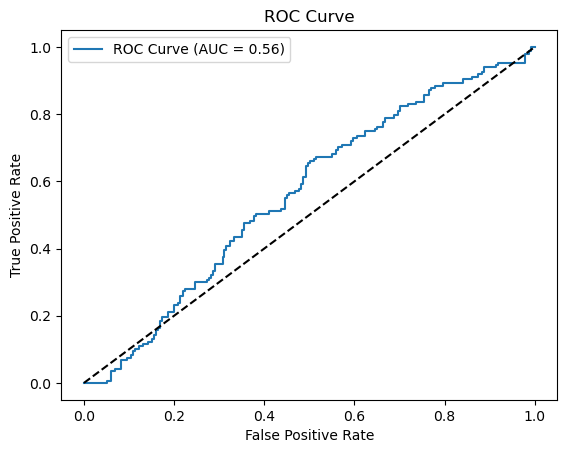

In [144]:
lbl_np = np.concatenate(all_labels)
prob_np = np.concatenate(all_probs)
prob_np = np.max(prob_np, axis=1)

fpr, tpr, thresholds = roc_curve(lbl_np, prob_np)

# Plot the ROC Curve
plt.figure()
plt.plot(fpr, tpr, label="ROC Curve (AUC = {:.2f})".format(roc_auc_score(lbl_np, prob_np)))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line (random model)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="best")
plt.show()

In [145]:
val_losses_chrt = chkpnt['val_losses']
val_acc_chrt = chkpnt['val_acc']
trn_losses_chrt = chkpnt['train_losses']
trn_acc_chrt = chkpnt['train_acc']

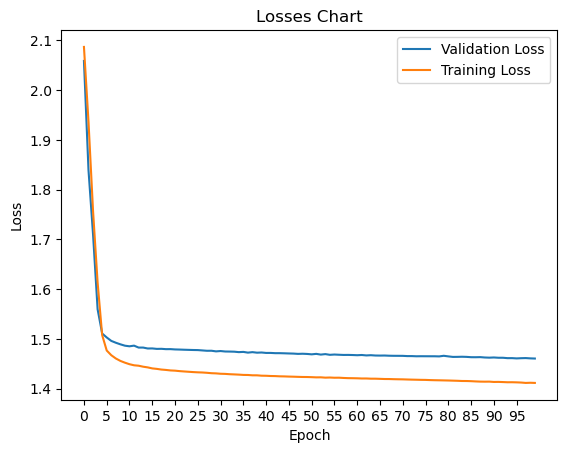

In [146]:
# print(losses)
epoch = np.arange(len(losses))
plt.plot(epoch,val_losses_chrt, trn_losses_chrt)
plt.legend(['Validation Loss', 'Training Loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title('Losses Chart')
plt.xticks(np.arange(0, 100, 5))
plt.show()

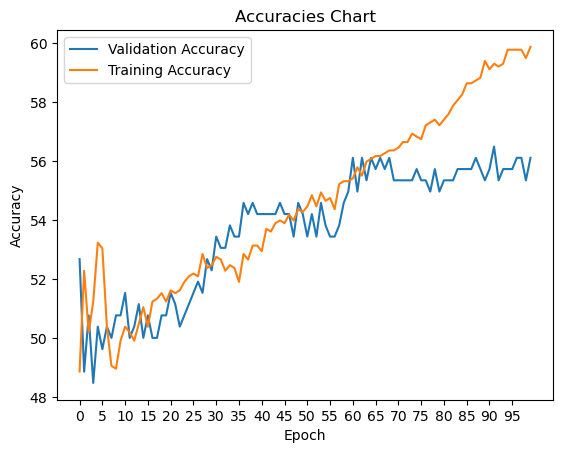

In [147]:
# print(losses)
epoch = np.arange(len(losses))
plt.plot(epoch,val_acc_chrt, trn_acc_chrt)
plt.legend(['Validation Accuracy', 'Training Accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title('Accuracies Chart')
plt.xticks(np.arange(0, 100, 5))
plt.show()

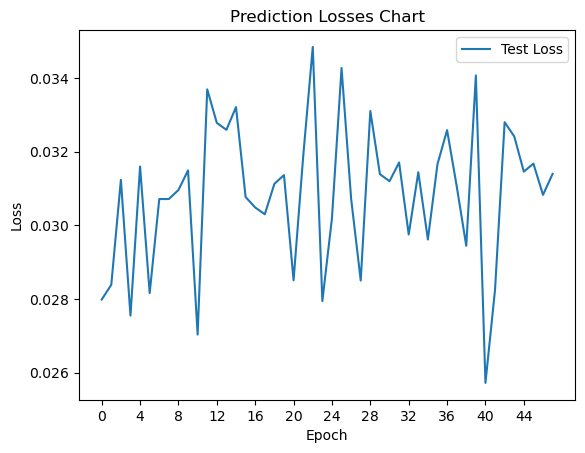

In [148]:
# print(losses)
epoch = np.arange(len(tst_losses))
plt.plot(epoch,tst_losses)
plt.legend(['Test Loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title('Prediction Losses Chart')
plt.xticks(np.arange(0, 48, 4))
plt.show()

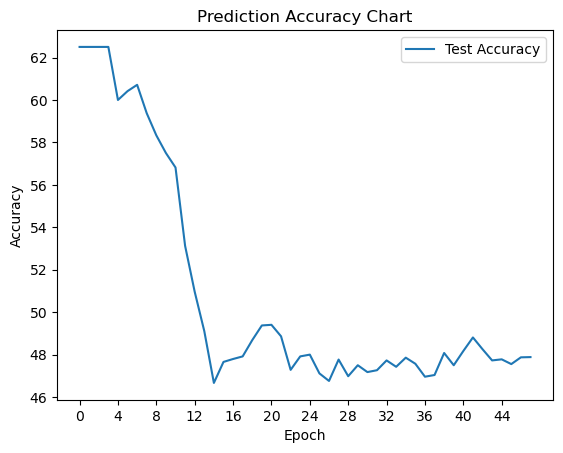

In [149]:
# print(losses)
epoch = np.arange(len(tst_losses))
plt.plot(epoch,tst_accuracies)
plt.legend(['Test Accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title('Prediction Accuracy Chart')
plt.xticks(np.arange(0, 48, 4))
plt.show()